# Methods and Results

We plan to use a K-Nearest Neighbors (KNN) classification model to predict whether a player will subscribe based on their age and experience.  
predictors: `Age` and `experience`  
response variable: `subscribe`
+ Firstly, I will load the packages that are necessary.
+ Then I'll use the URL to load the players dataset.
+ For the "wrangles and cleans the data" section, I'm going to select the required columns and filter out players with `played_hours` = 0, as these players may be inactive or may have registered for the game but never participated. What's more, I'll remove the missing values because they may impact the calculation.
+ For the "Data Preparation" section, I will apply One-Hot Encoding to convert `experience` into a numeric variable. I'l also convert `subscribe` into a factor variable. 

For the "Data analysis" section: 
+ I'll split the dataset into training and testing sets before modeling. Specifically, I will use 70% of the data for training and 30% for testing to evaluate model performance on unseen data.
+ Within the training data, I will apply 5-fold cross-validation to tune the value of K. In each fold, 80% of the training data will be used for training and 20% will be used as the validation set.
+ After running 5-fold cross-validation for each K value, I will look at the average accuracy of each model. The model with the highest average accuracy will be selected.
+ Finally, I'll use the best k to do a fix model and evaluate for accuracy, precision, and recall.

## 1. load package

In [1]:
library(tidyverse)
library(tidymodels)
library(kknn)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## 2. load data

In [2]:
url = 'https://drive.google.com/uc?export=download&id=1CwjG1G1zX1CAuvYRNh7vd07ETVWACEiA'
players <- read_csv(url)
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


## 3. wrangles and cleans the data 

In [3]:
players_new <- players |> 
filter(played_hours > 0) |>
select(c(1,2,7)) 
head(players_new)

experience,subscribe,Age
<chr>,<lgl>,<dbl>
Pro,TRUE,9
Veteran,TRUE,17
Amateur,TRUE,21
Regular,TRUE,21
Amateur,TRUE,47
Veteran,TRUE,23


In [4]:
players_new <- players_new |>
drop_na()
head(players_new)

experience,subscribe,Age
<chr>,<lgl>,<dbl>
Pro,TRUE,9
Veteran,TRUE,17
Amateur,TRUE,21
Regular,TRUE,21
Amateur,TRUE,47
Veteran,TRUE,23


## 4. players dataset summary

In [5]:
experience_categories <- players_new |>
     distinct(experience)
experience_categories

experience
<chr>
Pro
Veteran
Amateur
Regular
Beginner


In [6]:
subscribe_levels <- players_new |>
     distinct(subscribe)
subscribe_levels

subscribe
<lgl>
TRUE
FALSE


In [7]:
age_summary <- players_new |>
  summarize(age_mean = mean(Age, na.rm = TRUE),
            age_min = min(Age, na.rm = TRUE),
            age_max = max(Age, na.rm = TRUE),
            age_sd = sd(Age, na.rm = TRUE))
age_summary

age_mean,age_min,age_max,age_sd
<dbl>,<dbl>,<dbl>,<dbl>
21.30275,9,58,7.652771


In [8]:
dim(players_new)

[1] 109   3

### Players dataset overview:
+ number of observations: 109
+ number of variables: 3  

### The variables in players dataset are:
+ `experience` is a character variable that records player's experience level in the game, such as `Pro`,`Veteran`, `Amateur`, `Regular`, and `Beginner`.
+ `subscribe` is a logical variable that indicates whether the players subscribed to a game-related newsletter, with `TRUE` meaning subscribed and `FALSE` meaning not subscribed.
+ `Age` is a double variable that records the player's age in years. The mean `Age` is 21.30 years old, with a minimum of 9 years old, a maximum of 58 years old, and a standard deviation of 7.65 years old.

## 5. players dataset visualization

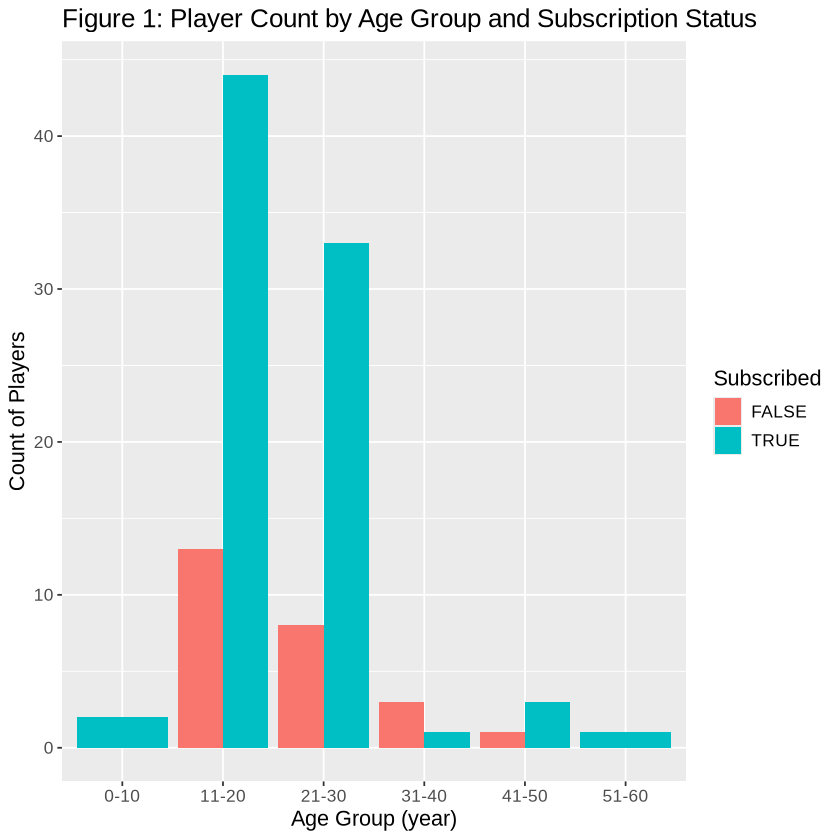

In [9]:
age_subscribe_bar <- players_new |>
  mutate(age_group = cut(Age, breaks = c(0, 10, 20, 30, 40, 50, 60),
                         labels = c("0-10", "11-20", "21-30", "31-40", "41-50", "51-60"))) |>
  ggplot(aes(x = age_group, fill = subscribe)) +
  geom_bar(position = "dodge") +
  labs(x = "Age Group (year)", y = "Count of Players",
       fill = "Subscribed",
       title = "Figure 1: Player Count by Age Group and Subscription Status")+
  theme(text = element_text(size=13))

age_subscribe_bar

Figure 1 shows that people between 11 and 30 years old subscribe the most compared to other age groups.

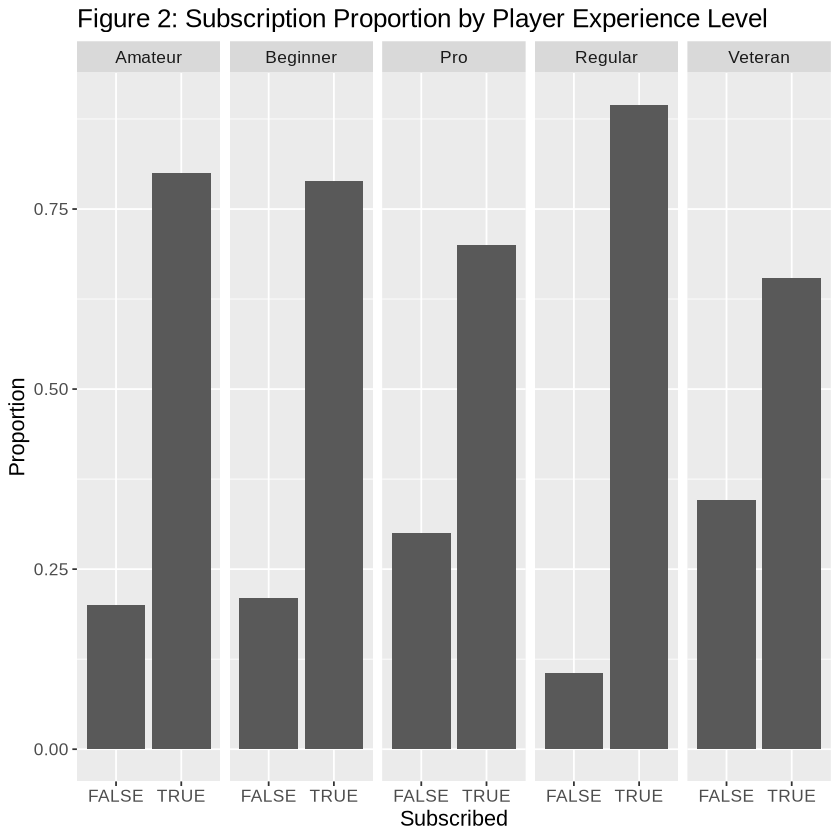

In [10]:
subscribe_experience_prop <- players_new |>
  ggplot(aes(x = subscribe, y = after_stat(prop), group = 1)) +
  geom_bar() +
  xlab("Subscribed") +
  ylab("Proportion") +
  facet_grid(cols = vars(experience)) +
  ggtitle("Figure 2: Subscription Proportion by Player Experience Level") +
  theme(text = element_text(size=13))
subscribe_experience_prop

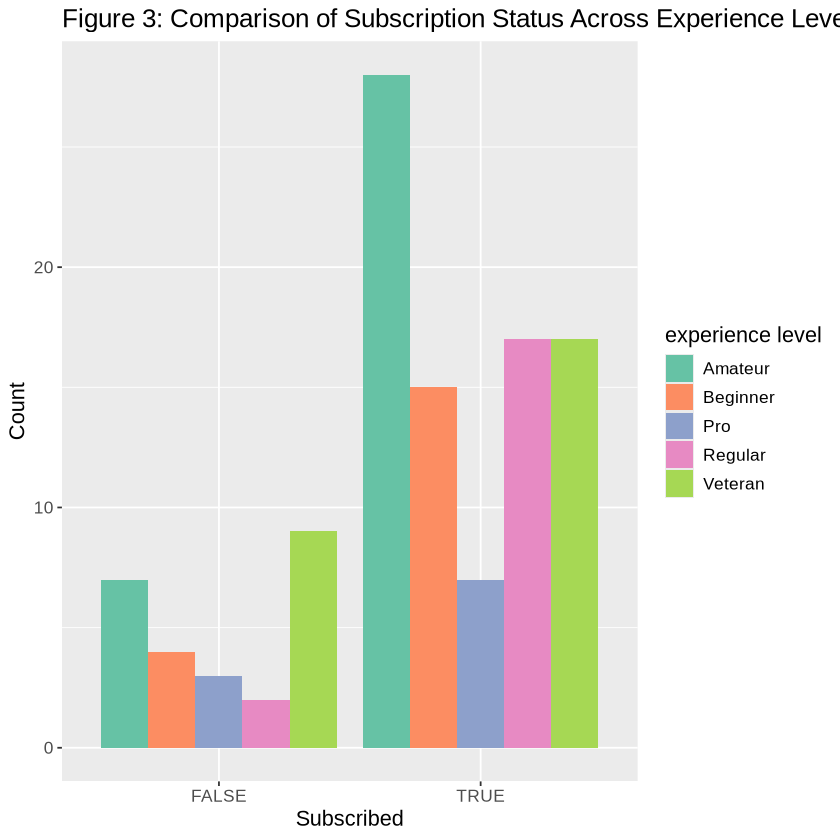

In [11]:
subscribe_experience <- ggplot(players_new, aes(x = subscribe)) + 
  geom_bar(aes(fill = experience), position = "dodge") +
  xlab("Subscribed") +
  ylab("Count") +
  scale_fill_brewer(palette = "Set2") +
  ggtitle("Figure 3: Comparison of Subscription Status Across Experience Levels") +
  labs(fill = "experience level") +
  theme(text = element_text(size=13))
subscribe_experience

Figure 2 shows that players at the Regular level have the highest subscription rate.Figure 3 above shows that experienced players (Veteran and Regular) have higher subscription proportions than Beginner and Pro players. It also shows that Amateur players make up most of the subscribers.

## 6. Data Preparation

In [12]:
players_new$experience <- factor(players_new$experience)
players_new$subscribe <- factor(players_new$subscribe)

# Apply One-Hot Encoding to convert experience into a numeric variable
encoded_experience <- model.matrix(~ experience - 1, data = players_new)

# Combine Age, subscribe, and the one-hot encoded experience variables
players_encoded <- players_new |>
  select(Age, subscribe, experience) |> 
  bind_cols(as_tibble(encoded_experience)) 
head(players_encoded)

Age,subscribe,experience,experienceAmateur,experienceBeginner,experiencePro,experienceRegular,experienceVeteran
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,TRUE,Pro,0,0,1,0,0
17,TRUE,Veteran,0,0,0,0,1
21,TRUE,Amateur,1,0,0,0,0
21,TRUE,Regular,0,0,0,1,0
47,TRUE,Amateur,1,0,0,0,0
23,TRUE,Veteran,0,0,0,0,1


In this part, I use one hot encoding to convert `experience` from a categorical variable to a numerical variable. I also convert `subscribe` from a logical variable to a factor variable. These transformations ensure that both variables are in suitable formats for the subsequent classification modeling process.

In [13]:
dim(players_encoded)

[1] 109   8

### Players dataset overview after encoding:
+ number of observations: 109
+ number of variables: 7  

### The variables in players dataset after encoding are:
+ `experienceAmateur`, `experienceBeginner`, `experiencePro`, `experienceRegular`, and `experienceVeteran` are double variables. Each variable takes a value of 0 or 1, indicating whether the player's experience level is Amateur, Beginner, Pro, Regular, or Veteran respectively. 
+ `subscribe` is a factor variable now.
+ `Age` is still a double variable that records the player's age in years.
+ `experience` is a character variable that records player's experience level in the game, such as `Pro`,`Veteran`, `Amateur`, `Regular`, and `Beginner`.

## 7. Data analysis

In [136]:
# Split the dataset into training and testing sets
set.seed(7654)
players_split <- initial_split(players_encoded, prop = 0.70, strata = subscribe)
players_train <- training(players_split)
players_test  <- testing(players_split)

In [137]:
# Prepares and preprocesses the data (normalization & selecting predictors)
players_recipe <- recipe(subscribe ~ Age + experienceAmateur + experienceBeginner + experiencePro + experienceRegular + experienceVeteran, data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())
players_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 6



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



In [138]:
# Specify KNN clssification model with tunable neighbors
players_tune <- nearest_neighbor(weight_func = "rectangular",neighbors   = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")
players_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [139]:
# Define candidate K values
players_kvalues <- tibble(neighbors = 1:20)

In [140]:
# Set up 5-fold cross-validation on training data
set.seed(7654)
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

In [141]:
# Create workflow and tune K using cross-validation
players_fit_tune <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_tune) |>
  tune_grid(resamples = players_vfold, grid = players_kvalues, control = control_grid(save_pred = TRUE))

In [142]:
# Collect accuracy results and identify best K
players_accuracy <- players_fit_tune |>
  collect_metrics() |>
  filter(.metric == "accuracy") |>
  arrange(desc(mean))
players_accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,accuracy,binary,0.7742857,5,0.03171642,Preprocessor1_Model06
9,accuracy,binary,0.7742857,5,0.01025193,Preprocessor1_Model09
10,accuracy,binary,0.7742857,5,0.01025193,Preprocessor1_Model10
13,accuracy,binary,0.7742857,5,0.01025193,Preprocessor1_Model13
14,accuracy,binary,0.7742857,5,0.01025193,Preprocessor1_Model14
15,accuracy,binary,0.7742857,5,0.01025193,Preprocessor1_Model15
16,accuracy,binary,0.7742857,5,0.01025193,Preprocessor1_Model16
17,accuracy,binary,0.7742857,5,0.01025193,Preprocessor1_Model17
18,accuracy,binary,0.7742857,5,0.01025193,Preprocessor1_Model18


In [143]:
# Select the best K value based on accuracy
best_kvalue <- players_accuracy |>
slice(1) |> 
pull(neighbors)
best_kvalue

[1] 6

In [144]:
# Train final KNN model using the best K
players_final <- nearest_neighbor(weight_func = "rectangular", neighbors = best_kvalue) |>
  set_engine("kknn") |>
  set_mode("classification")

players_workflow <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_final)

players_fit <- fit(players_workflow, data = players_train)

In [148]:
# Evaluate final KNN classification model
players_predictions <- predict(players_fit, players_test) |>
  bind_cols(players_test)

# Accuracy
players_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

# Precision
players_predictions |>
  precision(truth = subscribe, estimate = .pred_class, event_level = "first")

# Recall
players_predictions |>
  recall(truth = subscribe, estimate = .pred_class, event_level = "first")

players_confusion <- players_predictions |>
  conf_mat(truth = subscribe, estimate = .pred_class)
players_confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7058824


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.375


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.375


          Truth
Prediction FALSE TRUE
     FALSE     3    5
     TRUE      5   21

## Visualization of the analysis 

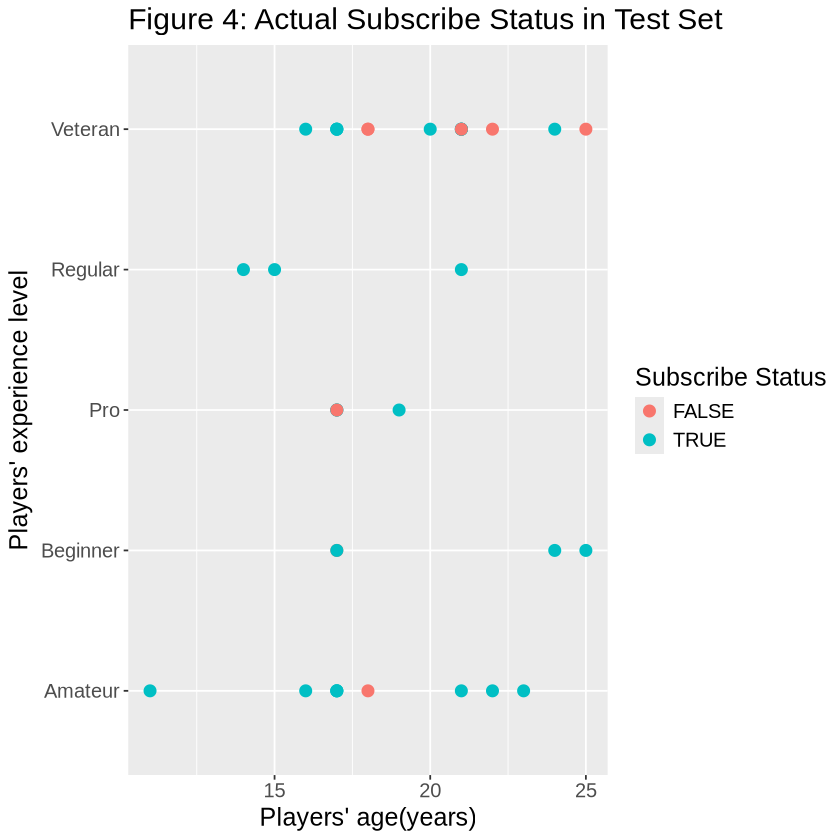

In [146]:
actual_subscribe <- ggplot(players_test, aes(x = Age, y = experience, color = subscribe)) +
  geom_point(size = 3) +
  labs(
    x = "Players' age(years)",
    y = "Players' experience level",
    title = "Figure 4: Actual Subscribe Status in Test Set",
    color = "Subscribe Status") +
    theme(text = element_text(size = 15))
actual_subscribe

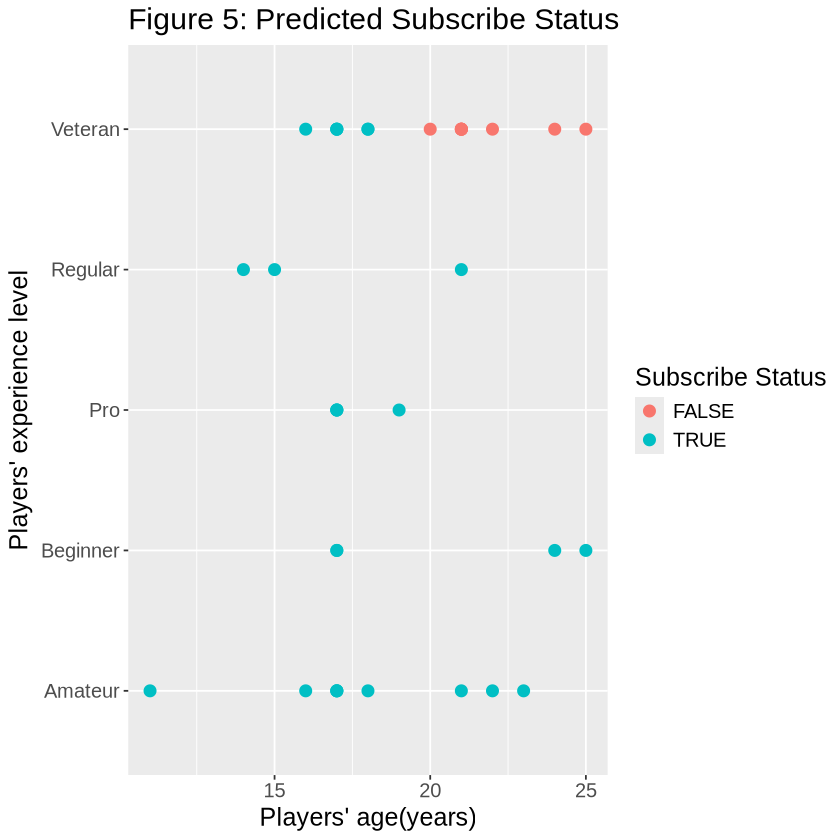

In [147]:
predicted_subscribe <- players_predictions |>
  ggplot(aes(x = Age, y = experience, color = .pred_class)) +
  geom_point(size = 3) +
  labs(
    x = "Players' age(years)",
    y = "Players' experience level",
    title = "Figure 5: Predicted Subscribe Status",
    color = "Subscribe Status"
  ) +
  theme(text = element_text(size = 15))
predicted_subscribe